# PGD attacks

This notebook tests **EuroSAT ResNet18 model** on images modified with **PGD attacks**.

### 1. Setup environment and imports

In [19]:
import sys, os, re
sys.path.append(os.path.abspath(".."))
if not hasattr(sys, "frozen"):
    os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"
import torch
import torch.nn as nn
from torchvision import models
import matplotlib.pyplot as plt
from PIL import Image
import glob
import numpy as np
import tifffile
from PIL import ImageEnhance
from skimage.transform import resize


from src.training.simple_cnn import SimpleCNN
from src.data.dataloader import get_dataloaders
from src.attacks.pgd import evaluate_pgd
from src.attacks.evaluate import evaluate_adv, plot_confusion_matrix

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model_name = "simplecnn" # or resnet18
data_dir = '../data/raw'
batch_size = 64

Using device: cpu


- Get path

In [20]:
if model_name == "simplecnn":
        checkpoint_path = "../experiments/checkpoints/simplecnn_best.pth"
elif model_name == "resnet18":
        checkpoint_path = "../experiments/checkpoints/resnet18_best.pth"


### 2. Load data and model

- Load dataloaders

In [21]:
train_loader, val_loader, test_loader, classes = get_dataloaders(data_dir=data_dir, batch_size=batch_size)
print(f'Loaded {len(classes)} classes: {classes}')

num_classes = len(classes)

Loaded 10 classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


- Load model

In [22]:
if model_name.lower() == "resnet18":
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
elif model_name.lower() == "simplecnn":
    model = SimpleCNN(num_classes=num_classes)
else:
    raise ValueError(f"Unsupported model_name: {model_name}")


### 3. Run PGD attacks and save adversarial images 

In [23]:
out_dir = '../data/adversarial/pgd'

eps = 0.05
alpha = eps / 10
iters = 20
       

res = evaluate_pgd(
    model=model,
    dataloader=test_loader,
    device=device,
    eps=eps,
    alpha=alpha,
    iters=iters,
    out_dir=out_dir,
    save_every=20, 
    max_save=64,
    targeted=False, 
    target_class=None
)
print('PGD run result:', res)


PGD run result: {'clean_acc': 0.0745679012345679, 'adv_acc': 0.05407407407407407, 'clean_loss': 2.3085268871872513, 'adv_loss': 2.317613542698048, 'eps': 0.05, 'saved': 64, 'out_dir': '/Users/joseantonioruizheredia/Code/Python/ml-satellite-adv/data/adversarial/pgd'}


### 4. Evaluate saved adversarial images for each epsilon

In [24]:
folder = f'../data/adversarial/pgd'

- Evaluation of metrics

In [25]:
print(f"\n=== Model Evaluation on adversarial images ===")
metrics_adv = evaluate_adv(
    adv_folder=folder,
    model_path=checkpoint_path,
    data_dir=data_dir,          
    batch_size=batch_size,
    model_name=model_name,
    device=device,
    mean_std_sample_size=2000,
    image_pattern="*.tif"
)

print(f"Num images: {metrics_adv['num_images']}")

print(f"Accuracy: {metrics_adv['accuracy']*100:.2f}%")
print(f"Loss: {metrics_adv['loss']:.4f}")
print(f"Precision: {metrics_adv['precision']:.4f}")
print(f"Recall: {metrics_adv['recall']:.4f}")
print(f"F1-score: {metrics_adv['f1']:.4f}")

print("\nClassification metrics per category:\n\n", metrics_adv["classification_report"])



=== Model Evaluation on adversarial images ===
Num images: 64
Accuracy: 4.69%
Loss: 8.3864
Precision: 0.0048
Recall: 0.1000
F1-score: 0.0091

Classification metrics per category:

                       precision    recall  f1-score   support

          AnnualCrop     0.0476    1.0000    0.0909         3
              Forest     0.0000    0.0000    0.0000         8
HerbaceousVegetation     0.0000    0.0000    0.0000         9
             Highway     0.0000    0.0000    0.0000         9
          Industrial     0.0000    0.0000    0.0000         7
             Pasture     0.0000    0.0000    0.0000         4
       PermanentCrop     0.0000    0.0000    0.0000         3
         Residential     0.0000    0.0000    0.0000         5
               River     0.0000    0.0000    0.0000         8
             SeaLake     0.0000    0.0000    0.0000         8

            accuracy                         0.0469        64
           macro avg     0.0048    0.1000    0.0091        64
        we

- Confusion Matrix

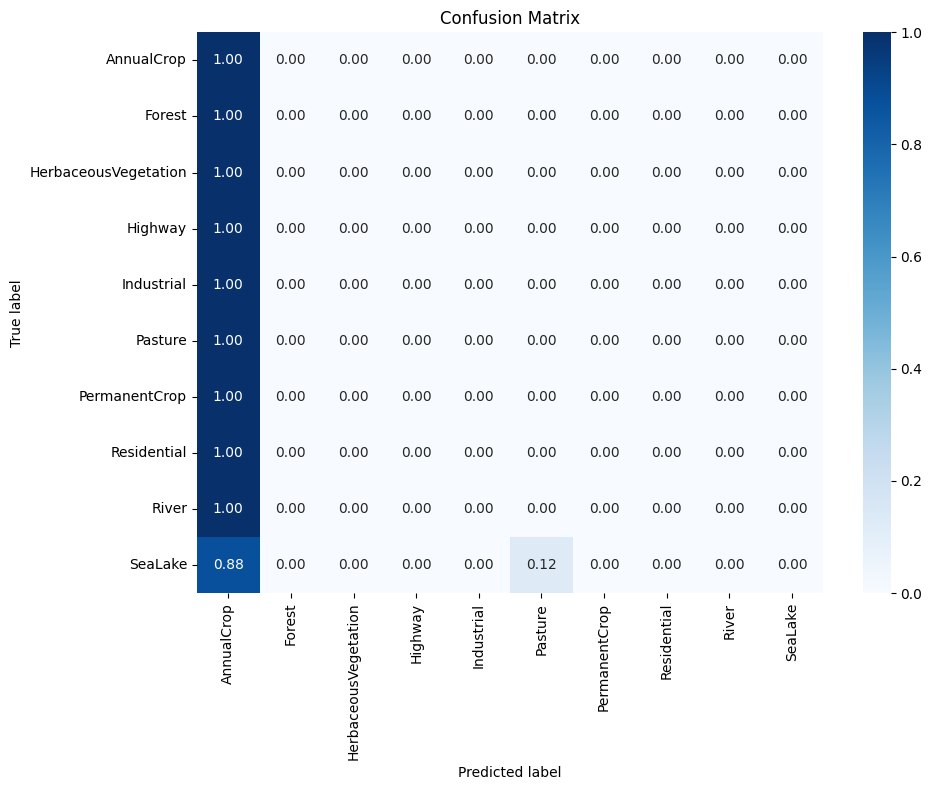

In [26]:
plot_confusion_matrix(metrics_adv['confusion_matrix'], metrics_adv['class_names'], normalize=True)

- Show a small sample of images 

In [27]:

def select_rgb_bands(img):
    if img.ndim == 3 and img.shape[2] >= 4:
        return img[:, :, [3,2,1]]
    if img.ndim == 2:
        return np.stack([img]*3, axis=-1)
    return img[:, :, :3]

def normalize_image(img, low=1, high=99):
    img = img.astype(np.float32)
    for c in range(img.shape[2]):
        p_low, p_high = np.percentile(img[:, :, c], (low, high))
        if p_high > p_low:
            img[:, :, c] = (img[:, :, c] - p_low) / (p_high - p_low)
        else:
            img[:, :, c] = 0
    return np.clip(img, 0, 1)

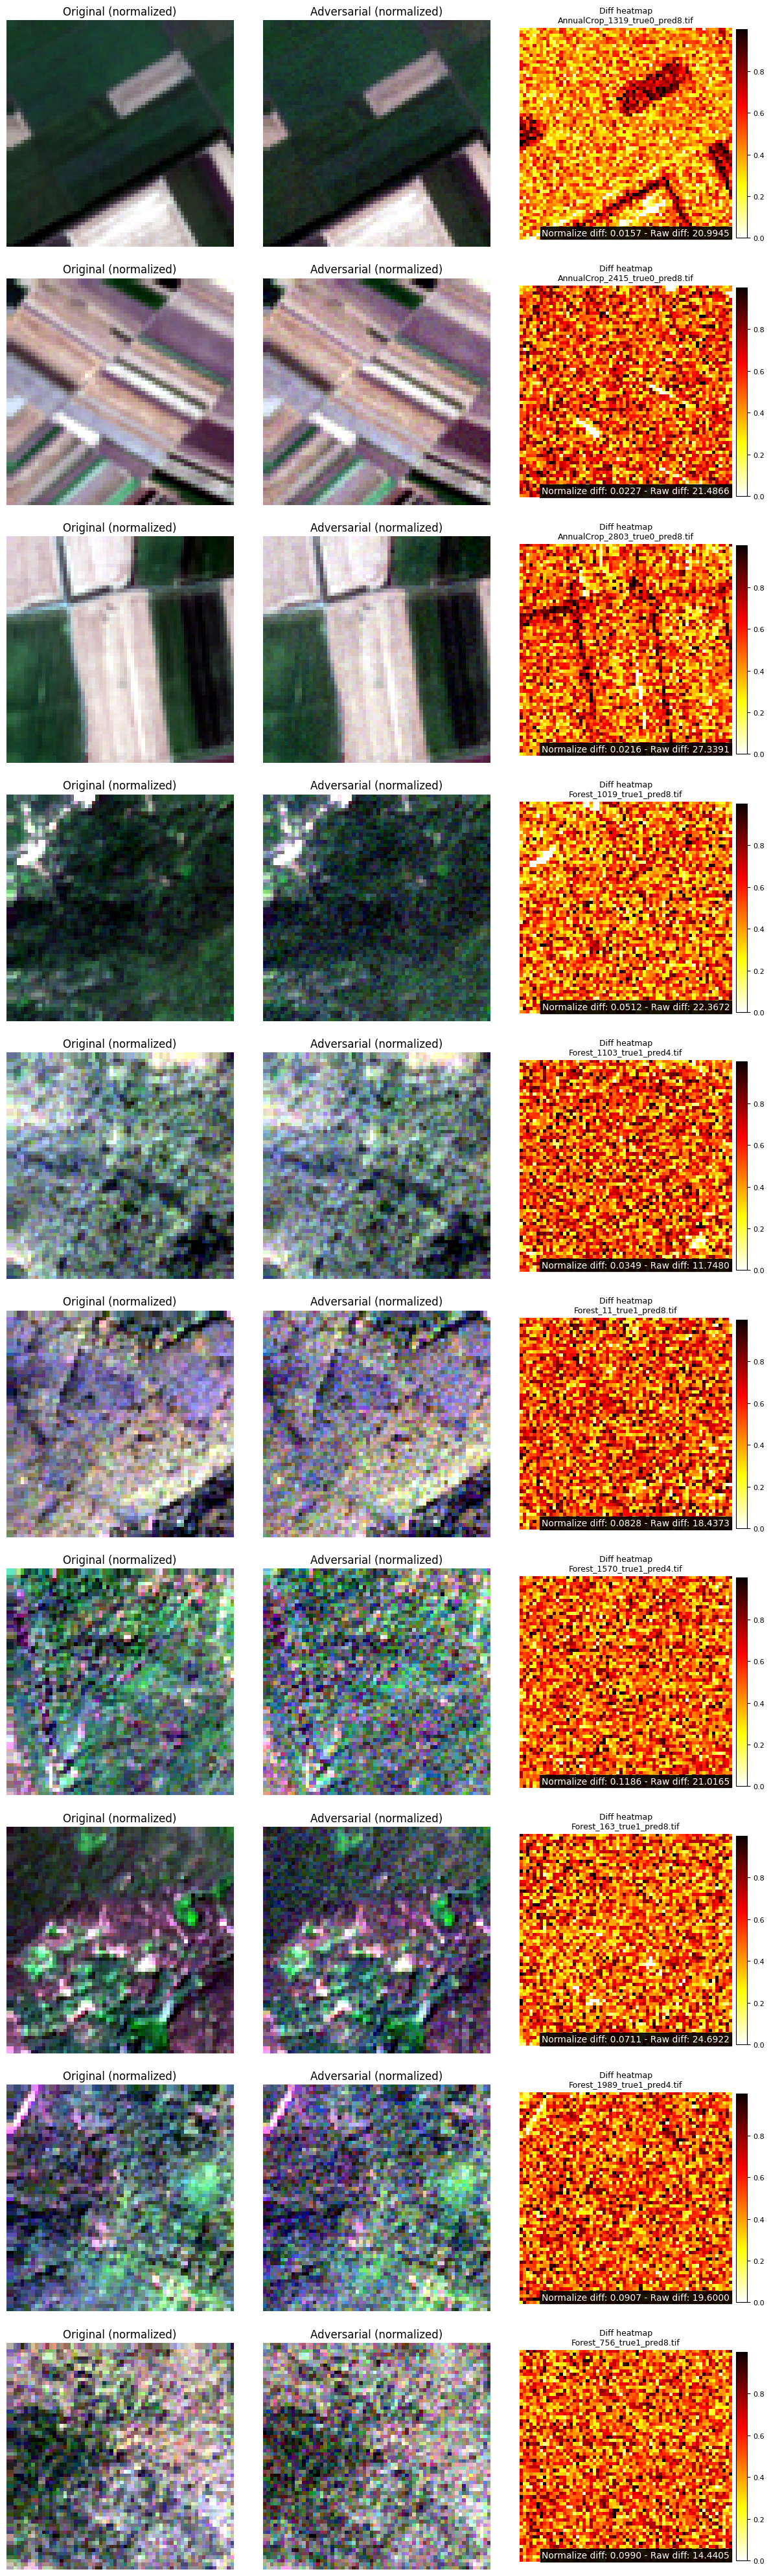

In [36]:
adv_folder = '../data/adversarial/pgd'
raw_folder = '../data/raw'
adv_paths = sorted(glob.glob(os.path.join(adv_folder, "*.tif")))

pairs = []
for adv_p in adv_paths:
    base = os.path.basename(adv_p)
    orig_base = re.sub(r"_true\d+_pred\d+\.tif$", ".tif", base)
    orig_candidates = glob.glob(os.path.join(raw_folder, "**", orig_base), recursive=True)
    if not orig_candidates:
        continue
    pairs.append((adv_p, orig_candidates[0]))

if len(pairs) == 0:
    print("No matching pairs found.")
else:
    pairs = pairs[:10]  # <=10 heatmaps

    # Create a single figure with len(pairs) rows and 3 cols
    fig, axs = plt.subplots(len(pairs), 3, figsize=(12, 4 * len(pairs)))
    axs = np.atleast_2d(axs)  # ensure 2D indexing even if len(pairs)==1

    for i, (adv_p, orig_p) in enumerate(pairs):
        adv = tifffile.imread(adv_p)
        orig = tifffile.imread(orig_p)
        
        raw_diff = np.abs(adv.astype(np.float32) - orig.astype(np.float32))


        # transpose if channels-first
        if adv.ndim == 3 and adv.shape[0] in [3,4,13]:
            adv = np.transpose(adv, (1,2,0))
        if orig.ndim == 3 and orig.shape[0] in [3,4,13]:
            orig = np.transpose(orig, (1,2,0))

        adv_rgb = select_rgb_bands(adv)
        orig_rgb = select_rgb_bands(orig)

        if adv_rgb.shape != orig_rgb.shape:
            orig_rgb = resize(orig_rgb, adv_rgb.shape, preserve_range=True, anti_aliasing=True)

        adv_disp = normalize_image(adv_rgb)
        orig_disp = normalize_image(orig_rgb)

        # 1) diferencia absoluta por canal -> promedio a mono
        diff = np.mean(np.abs(adv_disp - orig_disp), axis=2)  # 2D

        # 2) Realce/contraste del mapa:
        p99 = np.percentile(diff, 99)
        if p99 <= 0:
            p99 = diff.max() + 1e-12
        diff_clipped = np.clip(diff / (p99 + 1e-12), 0, 1)

        # 3) transforma para realzar pequeñas diferencias
        scale = 0.01
        diff_vis = np.log1p(diff_clipped * scale) / np.log1p(scale)

        # Fill subplots: original, adversarial, diff
        ax0 = axs[i, 0]
        ax1 = axs[i, 1]
        ax2 = axs[i, 2]

        ax0.imshow(orig_disp)
        ax0.set_title("Original (normalized)")
        ax0.axis("off")

        ax1.imshow(adv_disp)
        ax1.set_title("Adversarial (normalized)")
        ax1.axis("off")

        # Mostrar heatmap
        im = ax2.imshow(diff_vis, cmap='hot_r', interpolation='nearest')
        ax2.set_title(f"Diff heatmap\n{os.path.basename(adv_p)}", fontsize=9)
        ax2.axis("off")

        # Añadir una etiqueta con stats sobre la diferencia
        normalize_diff = diff.mean()
        raw_diff = raw_diff.mean()
        ax2.text(
            0.99, 0.01,  
            f"Normalize diff: {normalize_diff:.4f} - Raw diff: {raw_diff:.4f}",
            color='white',
            fontsize=10,
            ha='right',
            va='bottom',
            transform=ax2.transAxes,
            bbox=dict(facecolor='black', alpha=0.9, pad=2)
        )

        # Colorbar pequeña al lado
        cbar = fig.colorbar(im, ax=ax2, fraction=0.046, pad=0.02)
        cbar.ax.tick_params(labelsize=8)
        

    plt.tight_layout()
    plt.show()